Instruction for TA: We have two files. 

* one of them includes our custom nerual network model and a Resnet-18 model.
* other one includes our final model which is a Resnet-50 Model.

We attached two ipynb files into the project zip





THIS OUR FIRST CNN MODEL

In [1]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import pandas as pd
import torch.optim.lr_scheduler as lr_scheduler
from torchvision.models import resnet18

# load and mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir('/content/gdrive/MyDrive')

# Verify that the working directory has been changed
print("New working directory:", os.getcwd())

import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import pandas as pd


train_data = pickle.load(open('./Train.pkl', 'rb'), encoding='bytes')
train_labels = np.genfromtxt('./Train_labels.csv', delimiter=',', skip_header=1)[:, 1].astype(int)
train_labels = torch.from_numpy(train_labels).long()
train_labels = train_labels.cuda()
# plt.imshow(train_data[0,:,:].squeeze(),cmap='gray')

# Split data into training and validation sets:
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

# Prepare the dataset and dataloader classes:

class CustomDataset(Dataset):
    def __init__(self, data, targets=None, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx].reshape(28, 28, 1)
        if self.transform:
            image = self.transform(image)

        if self.targets is not None:
            label = self.targets[idx]
            return image.cuda(), label.cuda()
        else:
            return image.cuda()

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = CustomDataset(train_data, train_labels, transform)
val_dataset = CustomDataset(val_data, val_labels, transform)
#playing with batch size
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define the neural network architecture:
class Net(nn.Module):
    def __init__(self):
      # Modifying the architecture to get better result:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(9216, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.ReLU()(x) #adding ReLU acivation function
        x = self.conv2(x)
        x = self.bn2(x)
        x = nn.ReLU()(x)
        x = self.dropout1(x)
        x = nn.MaxPool2d(2)(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.LeakyReLU(0.01)(x) # Leaky ReLU with negative slope 0.01
        x = self.dropout2(x)
        x = self.fc2(x)
        return nn.LogSoftmax(dim=1)(x)


model = Net()
model.cuda() # Move the model to the GPU
# Define the loss function and optimizer:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#Learning rate scheduling: Gradually reduce the learning rate during training. This can help the optimizer find a better minimum.

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
# Train the model:

num_epochs = 21
best_val_loss = float('inf')
epochs_without_improvement = 0
patience = 4  # Number of epochs without improvement to trigger early stopping


for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
#adding scheduler
    val_loss /= len(val_loader)
    scheduler.step(val_loss)

    train_accuracy = train_correct / train_total
    val_accuracy = val_correct / val_total
# adding early stopping trigger
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement == patience:
        print("Early stopping triggered")
        break

    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss / len(train_loader)}, Training Accuracy: {train_accuracy}, Validation Loss: {val_loss / len(val_loader)}, Validation Accuracy: {val_accuracy}')


    # Load test data:
test_data = pickle.load(open('./Test.pkl', 'rb'), encoding='bytes')
test_dataset = CustomDataset(test_data, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Make predictions on test data:
model.eval()
predictions = []

with torch.no_grad():
    for images in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        if torch.cuda.is_available():
            predicted = predicted.cpu() # Move the tensor to the CPU
        predictions.extend(predicted.numpy())

predictions = np.array(predictions)



# Create a DataFrame with the correct column names and predicted labels
submission_df = pd.DataFrame({'id': list(range(0, len(predictions))), 'class': predictions})

# Save the DataFrame to a .csv file
submission_df.to_csv('ExampleSubmission.csv', index=False, header=['id', 'class'])

Mounted at /content/gdrive
New working directory: /content/gdrive/MyDrive
Epoch 1/21, Training Loss: 1.894390785853068, Training Accuracy: 0.30252083333333335, Validation Loss: 0.0068408172828895355, Validation Accuracy: 0.59325
Epoch 2/21, Training Loss: 1.3171183138688405, Training Accuracy: 0.5479166666666667, Validation Loss: 0.004342199088613498, Validation Accuracy: 0.7374166666666667
Epoch 3/21, Training Loss: 0.9811632064978282, Training Accuracy: 0.6725208333333333, Validation Loss: 0.003402177537017788, Validation Accuracy: 0.79675
Epoch 4/21, Training Loss: 0.7474973992904027, Training Accuracy: 0.7558333333333334, Validation Loss: 0.0026317401234719913, Validation Accuracy: 0.8446666666666667
Epoch 5/21, Training Loss: 0.6088962957461675, Training Accuracy: 0.8034791666666666, Validation Loss: 0.0022400938030947867, Validation Accuracy: 0.8725
Epoch 6/21, Training Loss: 0.5117960149049758, Training Accuracy: 0.8345208333333334, Validation Loss: 0.001942101587326805, Validat

ResNet18 Model - Second model

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
New working directory: /content/gdrive/MyDrive
(60000, 1, 28, 28)
Epoch 1/50, Training Loss: 1.668434096256892, Training Accuracy: 0.39177083333333335, Validation Loss: 1.372485857377661, Validation Accuracy: 0.5359166666666667
Epoch 2/50, Training Loss: 0.98552450243632, Training Accuracy: 0.6747083333333334, Validation Loss: 0.7358192933049608, Validation Accuracy: 0.7634166666666666
Epoch 3/50, Training Loss: 0.7913856761455536, Training Accuracy: 0.747125, Validation Loss: 0.5337924043390345, Validation Accuracy: 0.8269166666666666
Epoch 4/50, Training Loss: 0.6467430551846822, Training Accuracy: 0.7933541666666667, Validation Loss: 0.5051089155071593, Validation Accuracy: 0.8403333333333334
Epoch 5/50, Training Loss: 0.5604501518805822, Training Accuracy: 0.8210833333333334, Validation Loss: 0.43480009538062075, Validation Accuracy: 0.861
Epoch 6/50, T

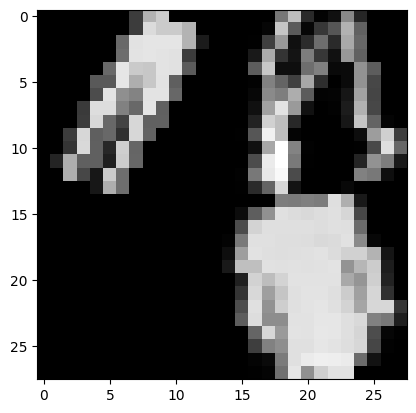

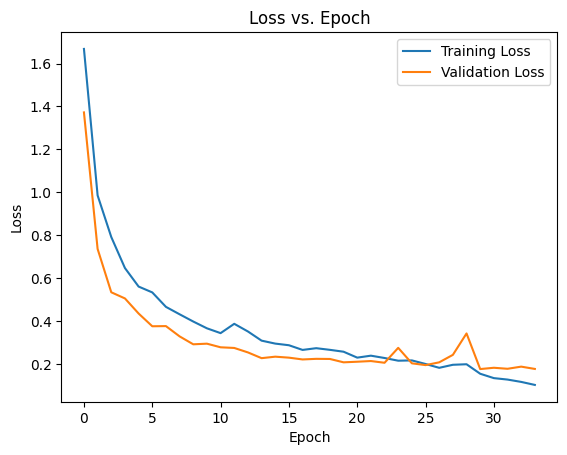

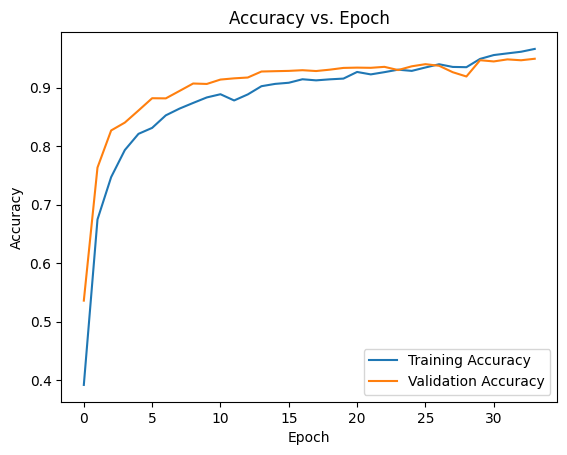

In [5]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
import pandas as pd
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt

# load and mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir('/content/gdrive/MyDrive')

# Verify that the working directory has been changed
print("New working directory:", os.getcwd())

# Load the training data and labels
train_data = pickle.load(open('./Train.pkl', 'rb'), encoding='bytes')
train_labels = np.genfromtxt('./Train_labels.csv', delimiter=',', skip_header=1)[:, 1].astype(int)

# Convert the training labels to a PyTorch tensor and move to GPU
train_labels = torch.from_numpy(train_labels).long()
train_labels = train_labels.cuda()
# ploting the data set

plt.imshow(train_data[0,:,:].squeeze(),cmap='gray')
print(train_data.shape)

# Split the training data into a training set and a validation set
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

# Define a custom dataset class to load the data
class CustomDataset(Dataset):
    def __init__(self, data, targets=None, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx].reshape(28, 28, 1)
        if self.transform:
            image = self.transform(image)

        if self.targets is not None:
            label = self.targets[idx]
            return image.cuda(), label.cuda()
        else:
            return image.cuda()

# Data augmentation Part: Define the data transformations for the training and validation sets*
transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_val = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create custom dataset instances for the training and validation sets
train_dataset = CustomDataset(train_data, train_labels, transform_train)
val_dataset = CustomDataset(val_data, val_labels, transform_val)

# Define the batch size* played with this parameter to find proper one*
batch_size = 64

# Create data loaders for the training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Loading the ResNet-18 model and modify the last layer to output 10 classes*

# Loading the ResNet-18 model and modify the last layer to output 10 classes*
model = models.resnet18(pretrained=True)

# Unfreeze all layers for fine-tuning*** Fine-tune the model: Instead of only training the last layer, fine-tune the entire network by unfreezing some or all of the layers. This allows the model to learn features specific to your dataset. 
# for param in model.parameters():
#     param.requires_grad = True

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.cuda()

# Define the loss function and optimizer** using 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the learning rate scheduler*
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Set the number of epochs and the early stopping patience*
num_epochs = 50
best_val_loss = float('inf')
epochs_without_improvement = 0
patience = 4

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Set the model to training mode
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    # Loop over the training data in batches*
    for images, labels in train_loader:
         # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        # Calculate the training loss and accuracy
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)
# Set the model to evaluation mode
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    # Loop over the validation data in batches
    with torch.no_grad():
        for images, labels in val_loader:
          # Make predictions
            outputs = model(images)
            loss = criterion(outputs, labels)
            # Calculate the validation loss and accuracy
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
# Calculate the average validation loss and accuracy*
    val_loss /= len(val_loader)
    scheduler.step(val_loss)

    train_accuracy = train_correct / train_total
    val_accuracy = val_correct / val_total

    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
# early stopping*
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement == patience:
        print("Early stopping triggered")
        break

    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss / len(train_loader)}, Training Accuracy: {train_accuracy}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

# Plotting loss
plt.figure()
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs. Epoch")
plt.show()

# Plotting accuracy
plt.figure()
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs. Epoch")
plt.show()

transform_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_data = pickle.load(open('./Test.pkl', 'rb'), encoding='bytes')
test_labels = np.genfromtxt('./Test_labels.csv', delimiter=',', skip_header=1)[:, 1].astype(int)
test_dataset = CustomDataset(test_data, test_labels, transform=transform_test)
test_labels = torch.from_numpy(test_labels).long()
test_labels = test_labels.cuda()
# Create a data loader for the test data
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Load the saved best model and make predictions on the test data
model.eval()
predictions = []

with torch.no_grad():
    for images in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        if torch.cuda.is_available():
            predicted = predicted.cpu()
        predictions.extend(predicted.numpy())

predictions = np.array(predictions)

correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the model on the test set: %d%%' % (100 * correct / total))

submission_df = pd.DataFrame({'id': list(range(0, len(predictions))), 'class': predictions})
submission_df.to_csv('ExampleSubmission.csv', index=False, header=['id', 'class'])
